In [1]:

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import pandas as pd
from functools import reduce
import operator
import math


# combine multiple lists and then calculate the centerpoint of all of them
def calc_megacenter(shape_list):
    coords = []
    
    for shape in shape_list:
        for coord_tuple in shape:
            coords.append(coord_tuple)
            
    center = tuple(map(operator.truediv, reduce(lambda x, y: map(operator.add, x, y), coords), [len(coords)] * 2))
        
    return center
    
    
def import_and_sort(filename):
    
    # import
    shape0 = pd.read_csv(filename)
    coords = list(shape0.itertuples(index=False, name=None))
    
    # determine center of coordinate cloud
    center = tuple(map(operator.truediv, reduce(lambda x, y: map(operator.add, x, y), coords), [len(coords)] * 2))

    # sort by the degree of rotation from 0, going counter-clockwise
    sorted_coords = sorted(coords, key=lambda coord: (-135 - math.degrees(math.atan2(*tuple(map(operator.sub, coord, center))[::-1]))) % 360)

    return sorted_coords
        
        
# # import, sort, rotate, flip
# def import_and_rotate(filename):
    
#     # import
#     shape0 = pd.read_csv(filename)
#     coords = list(shape0.itertuples(index=False, name=None))
    
#     # determine center of coordinate cloud
#     center = tuple(map(operator.truediv, reduce(lambda x, y: map(operator.add, x, y), coords), [len(coords)] * 2))

#     # sort by the degree of rotation from 0, going counter-clockwise
#     sorted_coords = sorted(coords, key=lambda coord: (-135 - math.degrees(math.atan2(*tuple(map(operator.sub, coord, center))[::-1]))) % 360)
   
#     # rotate all coords 180 around center
#     new_coords = []
    
#     for coord_tuple in sorted_coords:
#         new_coords.append(rotate(origin=center, point=coord_tuple, angle=180))
    
#     return new_coords


# rotate each coord tuple in the shape around the origin point, angle degrees
def rotate_shape(origin, shape, angle):
    new_shape = []
    angle_rad = angle * 0.0174444
    
    # origin coords
    ox, oy = origin[0], origin[1]

    for coord_tup in shape:
        px, py = coord_tup[0], coord_tup[1]
        
        qx = ox + math.cos(angle_rad) * (px - ox) - math.sin(angle_rad) * (py - oy)
        qy = oy + math.sin(angle_rad) * (px - ox) + math.cos(angle_rad) * (py - oy)
        
        new_shape.append((qx , qy))
        
    return new_shape

def flip_shape(origin, shape):
    new_shape = []
    
    # origin coords
    ox, oy = origin[0], origin[1]

    for coord_tup in shape:
        px, py = coord_tup[0], coord_tup[1]
        
        qx = ox + (ox - px)
        
        new_shape.append((qx, py))      
        
    return new_shape

def flip_shape_vert(origin, shape):
    new_shape = []
    
    # origin coords
    ox, oy = origin[0], origin[1]

    for coord_tup in shape:
        px, py = coord_tup[0], coord_tup[1]
        
        qy = oy + (oy - py)
        
        new_shape.append((px, qy))      
        
    return new_shape

def translate_shape_to_origin(shape):
    x_values = []
    y_values = []
    new_shape = []
    
    for (x, y) in shape:
        x_values.append(x)
        y_values.append(y)
    
    x_max, x_min = max(x_values), min(x_values)
    y_max, y_min = max(y_values), min(y_values)
    x_translate = (x_max - x_min) / 2
    y_translate = (y_max - y_min) / 2
    
    # translate to origin
    x_values = [(x - x_translate) for x in x_values]
    y_values = [(y - y_translate) for y in y_values]       
    
    for i in range(0, len(x_values)):
        new_shape.append((x_values[i], y_values[i])) 
        
    return new_shape

def scale_shape(shape, x_scaler, y_scaler):
    x_values = []
    y_values = []
    new_shape = []
    
    # bring shape to origin
    for (x, y) in shape:
        x_values.append(x)
        y_values.append(y)
    
    x_max, x_min = max(x_values), min(x_values)
    y_max, y_min = max(y_values), min(y_values)
    x_translate = (x_max - x_min) / 2
    y_translate = (y_max - y_min) / 2
    
    # translate to origin, scale, then translate back
    x_values = [((x - x_translate) * x_scaler) + x_translate for x in x_values]
    y_values = [((y - y_translate) * y_scaler) + y_translate for y in y_values]
       
    for i in range(0, len(x_values)):
        new_shape.append((x_values[i], y_values[i])) 
        
    return new_shape


# reorient shapes on the fly
def reorient_shapes(shape_list, angle, flip_axis, offset, x_scaler, y_scaler):    
    shape_list_flipped = []
    shape_list_rotated = []
    shape_list_offset = []
    export_list = []
    
    # get center of existing shape
    center = calc_megacenter(shape_list)
    
    for shape in shape_list:
        if flip_axis == "h":
            new_shape = flip_shape(origin = center, shape=shape)
            shape_list_flipped.append(new_shape)
        if flip_axis == "v":
            new_shape = flip_shape_vert(origin = center, shape=shape)
            shape_list_flipped.append(new_shape)
        if flip_axis == "none":
            shape_list_flipped.append(shape)

    
    new_center = calc_megacenter(shape_list_flipped)
    
    for shape in shape_list_flipped:
        # now we rotate it
        new_shape = rotate_shape(origin=new_center, shape=shape, angle=angle)
        shape_list_rotated.append(new_shape)
        
        
    # now we offset the shape
    
    for shape in shape_list_rotated:
        new_shape = [(coord_tuple[0] + offset[0], coord_tuple[1] + offset[1]) for coord_tuple in shape]
        shape_list_offset.append(new_shape)
        
    # scale the shape
    for shape in shape_list_offset:
        new_shape = scale_shape(shape, x_scaler, y_scaler)
        export_list.append(new_shape)
    
        
    return export_list
        

def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy




In [2]:
# list of the shapes for this polygon structure



c2_files = ["c:/data/grana_diffusion/res/psii_vertices/C2_mid_piece.csv", 
              "c:/data/grana_diffusion/res/psii_vertices/part1_C2.csv",
              "c:/data/grana_diffusion/res/psii_vertices/part2_C2.csv",
              "c:/data/grana_diffusion/res/psii_vertices/part3_C2.csv",
              "c:/data/grana_diffusion/res/psii_vertices/part4_C2.csv",
              "c:/data/grana_diffusion/res/psii_vertices/part5_C2.csv",
              "c:/data/grana_diffusion/res/psii_vertices/part6_C2.csv",
              "c:/data/grana_diffusion/res/psii_vertices/part7_C2.csv",
              "c:/data/grana_diffusion/res/psii_vertices/part8_C2.csv",
              "c:/data/grana_diffusion/res/psii_vertices/part9_C2.csv",
              "c:/data/grana_diffusion/res/psii_vertices/part10_C2.csv" 
              ]
# lhc_trimer
lhc_files = ["c:/data/grana_diffusion/res/psii_vertices/lhc_trimer.csv"]

# cp24
cp24_files = ["c:/data/grana_diffusion/res/psii_vertices/CP24_part1.csv",
              "c:/data/grana_diffusion/res/psii_vertices/CP24_part2.csv",
              "c:/data/grana_diffusion/res/psii_vertices/CP24_part3.csv",
              "c:/data/grana_diffusion/res/psii_vertices/CP24_part4.csv"
              ]

# cp26
cp26_files = ["c:/data/grana_diffusion/res/psii_vertices/CP26_part1.csv",
              "c:/data/grana_diffusion/res/psii_vertices/CP26_part2.csv",
              "c:/data/grana_diffusion/res/psii_vertices/CP26_part3.csv",
              "c:/data/grana_diffusion/res/psii_vertices/CP26_part4.csv",
              "c:/data/grana_diffusion/res/psii_vertices/CP26_part4.csv",
              "c:/data/grana_diffusion/res/psii_vertices/CP26_part5.csv"
              ]

# cp29
cp29_files = ["c:/data/grana_diffusion/res/psii_vertices/CP29.csv"]

    
# create the list of sorted coordinates of each shape

# c2 shapes, just flipped
c2_shapes = [import_and_sort(x) for x in c2_files]
center = calc_megacenter(c2_shapes)
c2_shapes_flipped = [flip_shape_vert(origin=center, shape=x)for x in c2_shapes]
# c2_shapes_rotated = [rotate_shape(origin=calc_megacenter(c2_shapes), shape=x, angle=45) for x in c2_shapes]

# cp24, flipped horizontally and then rotated 180 degrees
cp24_shapes = [import_and_sort(x) for x in cp24_files]
cp24_shapes_flipped = [flip_shape(origin = calc_megacenter(cp24_shapes), shape=x) for x in cp24_shapes]
cp24_shapes_rotated = [rotate_shape(origin=calc_megacenter(cp24_shapes_flipped), shape=x, angle=180)for x in cp24_shapes_flipped]

# cp26, flipped horizontally and then rotated 180 degrees
cp26_shapes = [import_and_sort(x) for x in cp26_files]
cp26_shapes_flipped = [flip_shape(origin=calc_megacenter(cp26_shapes), shape=x)for x in cp26_shapes]
cp26_shapes_rotated = [rotate_shape(origin=calc_megacenter(cp26_shapes_flipped), shape=x, angle=180)for x in cp26_shapes_flipped]

# cp29, flipped horizontally and then rotated 180 degrees
cp29_shapes = [import_and_sort(x) for x in cp29_files]
cp29_shapes_flipped = [flip_shape(origin = calc_megacenter(cp29_shapes), shape=x)for x in cp29_shapes]
cp29_shapes_rotated = [rotate_shape(origin = calc_megacenter(cp29_shapes_flipped), shape=x, angle=180)for x in cp29_shapes_flipped]




In [ ]:
print(scale_shape(cp29_shapes[0], x_scaler=1.16, y_scaler=1))


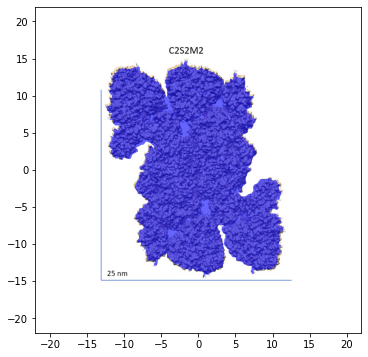

In [20]:
# plot only image and shape

# create a plot
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot()

# set the limits for the plot
limits = [-22, 22, -22, 22]
ax.set_xlim(limits[0], limits[1])
ax.set_ylim(limits[2], limits[3])
ax.set_aspect('equal', 'box')


# add an image as background and adjust it to scale
img = plt.imread("C:/data/grana_diffusion/C2S2M2_scale_733x733.png")
# C:\data\grana_diffusion\scale_sprites
offset = (-14.3, -15.8)
adj = 34
ax.imshow(img, extent=[offset[0],offset[0]+adj, offset[1], offset[1]+adj])

# name the plot
# fig.suptitle("components, adjusted coordinates")

# plot the c2s2m2
# assembled c2s2m2 mag
c2s2m2_shapes = [pd.read_csv("c:/data/grana_diffusion/25082021_1612_C2S2M2_points.csv")]

for coords in c2s2m2_shapes:
    polygon = Polygon(coords, True, facecolor='blue', alpha=.6)    
    ax.add_patch(polygon)  

plt.savefig("C:/data/grana_diffusion/082321_adjusted_scale_C2.png")
    



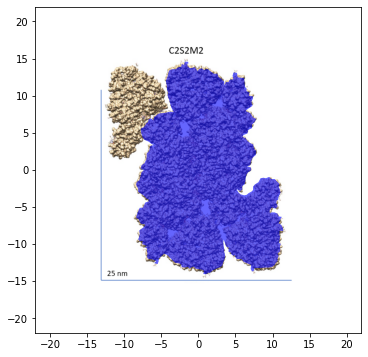

In [21]:

# plot only image and shape

# create a plot
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot()

# set the limits for the plot
limits = [-22, 22, -22, 22]
ax.set_xlim(limits[0], limits[1])
ax.set_ylim(limits[2], limits[3])
ax.set_aspect('equal', 'box')


# add an image as background and adjust it to scale
img = plt.imread("C:/data/grana_diffusion/C2S2M2_scale_733x733.png")
# C:\data\grana_diffusion\scale_sprites
offset = (-14.3, -15.8)
adj = 34
ax.imshow(img, extent=[offset[0],offset[0]+adj, offset[1], offset[1]+adj])

# name the plot
# fig.suptitle("components, adjusted coordinates")

# plot the c2s2m2
# assembled c2s2m2 mag
c2s2m2_shapes = [pd.read_csv("c:/data/grana_diffusion/25082021_1314_C2S2M_points.csv")]

for coords in c2s2m2_shapes:
    polygon = Polygon(coords, True, facecolor='blue', alpha=.6)    
    ax.add_patch(polygon)  

plt.savefig("C:/data/grana_diffusion/082321_adjusted_scale_C2.png")
    

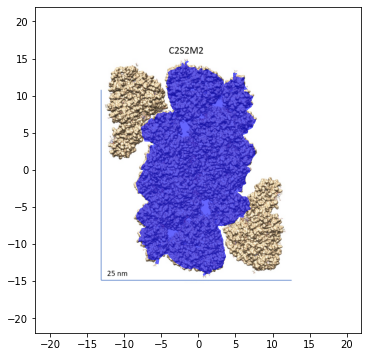

In [23]:

# plot only image and shape

# create a plot
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot()

# set the limits for the plot
limits = [-22, 22, -22, 22]
ax.set_xlim(limits[0], limits[1])
ax.set_ylim(limits[2], limits[3])
ax.set_aspect('equal', 'box')


# add an image as background and adjust it to scale
img = plt.imread("C:/data/grana_diffusion/C2S2M2_scale_733x733.png")
# C:\data\grana_diffusion\scale_sprites
offset = (-14.3, -15.8)
adj = 34
ax.imshow(img, extent=[offset[0],offset[0]+adj, offset[1], offset[1]+adj])

# name the plot
# fig.suptitle("components, adjusted coordinates")

# plot the c2s2m2
# assembled c2s2m2 mag
c2s2m2_shapes = [pd.read_csv("c:/data/grana_diffusion/25082021_1321_C2S2_points.csv")]

for coords in c2s2m2_shapes:
    polygon = Polygon(coords, True, facecolor='blue', alpha=.6)    
    ax.add_patch(polygon)  

plt.savefig("C:/data/grana_diffusion/082321_adjusted_scale_C2.png")
    

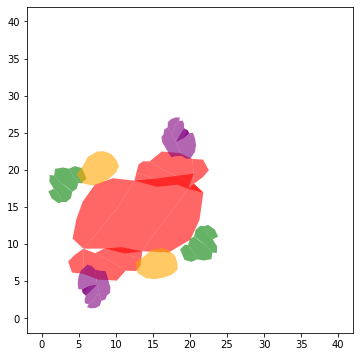

In [18]:
# comparing shapes with mag coords

# load mag coords C2S2M2
c2s2m2_shapes = [pd.read_csv("c:/data/grana_diffusion/25082021_1612_C2S2M2_points.csv")]

# create a plot
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot()

# set the limits for the plot
limits = [-2, 42, -2, 42]
ax.set_xlim(limits[0], limits[1])
ax.set_ylim(limits[2], limits[3])
ax.set_aspect('equal', 'box')


# add an image as background and adjust it to scale
img = plt.imread("C:/data/grana_diffusion/C2S2M2_scale_733x733.png")
# C:\data\grana_diffusion\scale_sprites
offset = (-1.7, -1.8)
adj = 34
# ax.imshow(img, extent=[offset[0],offset[0]+adj, offset[1], offset[1]+adj])

# name the plot
# fig.suptitle("components, adjusted coordinates")

#####  C2, RED #####   
# add the c2
for coords in reorient_shapes(c2_shapes, flip_axis="v", angle=-5, offset=(-1,4), x_scaler=1, y_scaler=1):
    polygon = Polygon(coords, True, facecolor='red', alpha=.6)    
    ax.add_patch(polygon)  

#####  CP26, PURPLE #####    
# add the cp26 in lower left
for coords in reorient_shapes(cp26_shapes, flip_axis="h", angle=15, offset=(-4.5,0.5), x_scaler=1, y_scaler=1):
    polygon = Polygon(coords, True, facecolor='purple', alpha=.6)    
    ax.add_patch(polygon)      
    
# add the cp26 in upper right
for coords in reorient_shapes(cp26_shapes, flip_axis="h", angle=210, offset=(7,21), x_scaler=1, y_scaler=1):
    polygon = Polygon(coords, True, facecolor='purple', alpha=.6)    
    ax.add_patch(polygon)   

#####  CP24, GREEN #####    
# add the cp24, upper left
for coords in reorient_shapes(cp24_shapes, flip_axis="v", angle=0, offset=(-8,14.5), x_scaler=1, y_scaler=1):
    polygon = Polygon(coords, True, facecolor='green', alpha=.6)    
    ax.add_patch(polygon) 

# # add the cp24, lower right
# for coords in reorient_shapes(cp24_shapes, flip_axis="h", angle=0, offset=(18,11)):
for coords in reorient_shapes(cp24_shapes, flip_axis="h", angle=0, offset=(10.5,6.5), x_scaler=1, y_scaler=1):
    polygon = Polygon(coords, True, facecolor='green', alpha=.6)    
    ax.add_patch(polygon) 
    
# #####  CP29, YELLOW #####        
# # add the cp29, upper left
# for coords in reorient_shapes(cp29_shapes, flip_axis="h", angle=200, offset=(4,25)):
for coords in reorient_shapes(cp29_shapes, flip_axis="h", angle=200, offset=(-3.5,17), x_scaler=1, y_scaler=1):
    polygon = Polygon(coords, True, facecolor='orange', alpha=.6)    
    ax.add_patch(polygon)  
    
# # add the cp29, lower right
for coords in reorient_shapes(cp29_shapes, flip_axis="h", angle=180, offset=(4.5,4), x_scaler=1, y_scaler=1):
    polygon = Polygon(coords, True, facecolor='orange', alpha=.6)    
    ax.add_patch(polygon)  
    
##
    
plt.savefig("C:/data/grana_diffusion/082321_adjusted_scale_C2.png")

In [ ]:
# create a plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()
ax.set_xlim(0, 50)
ax.set_ylim(-10, 40)
fig.suptitle("CP24, rotated 180 and then flipped horizontally")

# add all the patches for cp24    
for coords in cp24_shapes:
    polygon = Polygon(coords, True, facecolor='r')    
    ax.add_patch(polygon)
    
for coords in cp24_shapes_rotated:
    polygon = Polygon(coords, True, facecolor='g')    
    ax.add_patch(polygon)

    
plt.savefig("C:/data/grana_diffusion/cp24.png")
    

In [ ]:
# create a plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()
ax.set_xlim(0, 50)
ax.set_ylim(-10, 40)
fig.suptitle("CP26")


# add all the patches for CP26
for coords in cp26_shapes:
    polygon = Polygon(coords, True, facecolor='purple')    
    ax.add_patch(polygon)
    
for coords in cp26_shapes_rotated:
    polygon = Polygon(coords, True, facecolor='g')    
    ax.add_patch(polygon)

plt.savefig("C:/data/grana_diffusion/cp26.png")

In [ ]:
# create a plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()
ax.set_xlim(0, 50)
ax.set_ylim(-10, 40)
fig.suptitle("CP29")

# add all the patches for CP29
for coords in cp29_shapes:
    polygon = Polygon(coords, True, facecolor='blue')    
    ax.add_patch(polygon)
    
for coords in cp29_shapes_rotated:
    polygon = Polygon(coords, True, facecolor='g')    
    ax.add_patch(polygon)
    
plt.savefig("C:/data/grana_diffusion/cp29.png")